# Python test: User movie rating prediction with the MovieLens 20M dataset
In this exercise I was presented with a dataset containing information about different movies (identified with a movieId), their genre, release date and descriptive tags. The datasets also contains information about different users of the IMDB website, where these users are identified  with an userId and they can rate different movies. Not every user has given every movie a rating, but I have access to the existing ones. I also have information of the relevance that the descriptive tags have on some movies and how users have described some of the movies. The main objective is to predict whether a user will give a movie a high rating (>= 4) or low rating (< 4). We were given freedom to use the model and variables of our preference.

## 1. First look into the data and initial setup

Libraries to use in this mini-project, the first ones are pretty standard, the other one are more specific to tasks we are doing; supervised learning and for the use of regular expressions

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import re

We are now taking a first look into the data, because of time restraints, we are not doing a deeper EDA and we are just looking at the data type and headers. I am only loading all of them for demonstrative purposes

In [187]:
#First look into the movies dataset
movies_df = pd.read_csv('datasets/movie.csv')
display(movies_df.head())
movies_df.dtypes

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


movieId     int64
title      object
genres     object
dtype: object

This will be one of our more important datasets for the exercise, from here we can extract the movieId, title, genres and with some work, the year it was released.

In [188]:
#First look into the ratings dataset, we are dropping the column named timestamp because we have no use for it
ratings_df = pd.read_csv('datasets/rating.csv')
ratings_df = ratings_df.drop('timestamp',axis=1)
display(ratings_df.head())
ratings_df.dtypes

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


userId       int64
movieId      int64
rating     float64
dtype: object

This will be our other main dataset, we have the variable we are trying to predict with the column "rating". The dataframe contains the information of the rating that userId "X" gives to movie "Y". We can also join this dataset with the movie dataset thanks to the movieId field

In [189]:
#First look into genome_scores dataset. 
gs_df = pd.read_csv('datasets/genome_scores.csv')
display(gs_df.head())
gs_df.dtypes

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


movieId        int64
tagId          int64
relevance    float64
dtype: object

This dataset contains information about the relevance of each tag to describe the movieId, along with the tagId. The relevance field can be used as a descriptive variable for the models.

In [190]:
#First look into genome_tags dataset. 
gt_df = pd.read_csv('datasets/genome_tags.csv')
display(gt_df.head())
gt_df.dtypes

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


tagId     int64
tag      object
dtype: object

This dataset contains the names of the tagId, it might be useful to show the preferences a userId has. 

In [191]:
#First look into link dataset. 
link = pd.read_csv('datasets/link.csv')
display(link.head())
link.dtypes

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

At first glance, this dataset appears to have no relevant information for us.

In [192]:
#First look into tag dataset. 
tag = pd.read_csv('datasets/tag.csv')
display(tag.head())
tag.dtypes

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


userId        int64
movieId       int64
tag          object
timestamp    object
dtype: object

This document tells us which tags a user has given to a movie. At first glance we also won't be using it. So we are not bothering to remove the timestamp field.

## 2. General data preparation

We are going to expand the movies dataframe, so the year of release can be taken into consideration when building the model or creating some plots.

In [193]:
rex = '(\(\d+\))' #Regular expression used 
movies_year = movies_df.copy()
movies_year['year'] = movies_year['title'].str.extract(rex)                #Extract the digits in parenthesis
movies_year['year'] = movies_year['year'].str.strip('()')                  #Remove parenthesis from new column
#movies_year['year'].astype(str).astype(float)
movies_year['title'] = movies_year['title'].str.replace(rex,'',regex=True) #Remove the year in parenthesis from title column

movies_year.head()


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


We are going to prepare a dataframe that contains columns representing the different genres. It will contain a value of 1 if the movie belongs to the corresponding genre. We will use this base for a model where the predictive variables are the genres of the movie. One hot encoding was used

In [194]:
movies_genre = movies_year.copy()
movies_genre['genres'] = movies_genre.genres.str.split('|') #Split the genre value into a list with the separator being | 

for index, row in movies_genre.iterrows():                  #Loop through each row in the dataframe, 
    for genre in row['genres']:                             #Loops through each genre in the genre column of the current row
        movies_genre.at[index, genre] = 1                   #Sets the value 1 at the intersection of the row and the current column iteration, this is where columns are created. 
        
movies_genre = movies_genre.fillna(0)                       
movies_genre = movies_genre.drop('genres',axis=1)

movies_genre.tail()

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
27273,131254,Kein Bund für's Leben,2007,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27274,131256,"Feuer, Eis & Dosenbier",2002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27275,131258,The Pirates,2014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27276,131260,Rentun Ruusu,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27277,131262,Innocence,2014,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Another dataframe we are going to prepare, includes movieId and every tag (name or Id) as a column with the value being the relevance that this tag has for said movie. These will be the descriptive variables for another model that we will use to compare to the previous one

In [195]:
movies_tag_pre = movies_year.copy().drop('genres',axis=1)
tag_aux = gs_df.merge(gt_df, on='tagId', how='inner')

display(movies_tag_pre.head())
tag_aux.head()


,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,2,1,0.03975,007
2,3,1,0.04350,007
3,4,1,0.03725,007
4,5,1,0.04200,007


To bring this idea to life, I had to ask ChatGPT for help and optimization of the first code it gave me.

In [196]:
# Create a dictionary that maps movie IDs to their titles and years
movies_dict = dict(zip(movies_tag_pre['movieId'], movies_tag_pre[['title', 'year']].values))

# Pivot the tag_aux dataframe to create a matrix of relevance values for each movie ID and tag
tag_matrix = tag_aux.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge the tag matrix with the movies dataframe to add the movie title and year to each row
movies_tag = tag_matrix.merge(movies_tag_pre, on='movieId', how='inner')

# Reorder the columns to put the movie ID, title, and year first, followed by the tags
new_column_order = ['movieId', 'title', 'year'] + list(tag_aux['tag'].unique())
movies_tag = movies_tag[new_column_order]

In [197]:
movies_tag

,movieId,title,year,007,007 (series),18th century,1920s,1930s,1950s,1960s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,1,Toy Story,1995,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
1,2,Jumanji,1995,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
2,3,Grumpier Old Men,1995,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
3,4,Waiting to Exhale,1995,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
4,5,Father of the Bride Part II,1995,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10376,130578,The Gunman,2015,0.15400,0.04025,0.01975,0.01850,0.02850,0.02275,0.01000,...,0.02875,0.01125,0.01250,0.02050,0.21000,0.02375,0.04225,0.00525,0.07575,0.01325
10377,130840,Spring,2015,0.02400,0.03025,0.02425,0.09375,0.05600,0.06025,0.02100,...,0.02125,0.04250,0.01025,0.20350,0.47675,0.10775,0.06200,0.00775,0.27000,0.13375
10378,131013,Get Hard,2015,0.04200,0.03175,0.01700,0.05600,0.05750,0.02675,0.01600,...,0.06675,0.01300,0.01275,0.02275,0.20000,0.10750,0.02500,0.00950,0.07550,0.01625
10379,131168,Phoenix,2014,0.05975,0.10375,0.17850,0.14875,0.27750,0.16250,0.04125,...,0.20300,0.16325,0.81025,0.01900,0.18175,0.03225,0.04800,0.51925,0.06700,0.01725


We select the userId we want to do our prediction on with an input command

In [198]:
desiredUserId = int(input('Desired User ID: \n' ))
userRating_df = ratings_df.loc[ratings_df['userId'] == desiredUserId] #Select only the rows that correspond to the desired User Id
userRating_df.head()

Desired User ID: 
 1


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


We now, will join/merge the dataframe of movie_genres with the user ratings and the dataframe with tags with user ratings

In [199]:
df_genre_lr = userRating_df.merge(movies_genre, on='movieId', how='inner')
df_genre_lr = df_genre_lr[[col for col in df_genre_lr.columns if col != 'rating'] + ['rating']] #For personal formatting, I want the rating column to be the last one before the response variable 
df_genre_lr.head()

,userId,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed),rating
0,1,2,Jumanji,1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
1,1,29,"City of Lost Children, The (Cité des enfants p...",1995,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
2,1,32,Twelve Monkeys (a.k.a. 12 Monkeys),1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
3,1,47,Seven (a.k.a. Se7en),1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
4,1,50,"Usual Suspects, The",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5


In [200]:
df_tag_lr = userRating_df.merge(movies_tag, on='movieId', how='inner')
df_tag_lr = df_tag_lr[[col for col in df_tag_lr.columns if col != 'rating'] + ['rating']]
df_tag_lr.head()

,userId,movieId,title,year,007,007 (series),18th century,1920s,1930s,1950s,...,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies,rating
0,1,2,Jumanji,1995,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,...,0.01925,0.01725,0.02425,0.12550,0.02250,0.0155,0.01475,0.09025,0.01875,3.5
1,1,29,"City of Lost Children, The (Cité des enfants p...",1995,0.02350,0.02525,0.14275,0.28450,0.15525,0.08450,...,0.03100,0.02875,0.08900,0.17175,0.12875,0.1285,0.02675,0.04450,0.01700,3.5
2,1,32,Twelve Monkeys (a.k.a. 12 Monkeys),1995,0.02275,0.02325,0.07525,0.13525,0.15775,0.14675,...,0.04300,0.01275,0.07600,0.33750,0.16625,0.0430,0.01150,0.06600,0.02650,3.5
3,1,47,Seven (a.k.a. Se7en),1995,0.01925,0.01775,0.02000,0.06275,0.11350,0.09075,...,0.01675,0.02075,0.05700,0.24850,0.14275,0.0230,0.01600,0.05425,0.01950,3.5
4,1,50,"Usual Suspects, The",1995,0.02875,0.02900,0.07575,0.16025,0.21275,0.20225,...,0.01950,0.06300,0.06950,0.35525,0.27475,0.0425,0.04100,0.04725,0.02100,3.5


We are now prepared to start the ML models

# 3. Linear Regression ML models

The models I am more familiar with are Linear Regression, Logistic Regression and kNN. Mainly due to time constraints I will be using those, even though they may not be most accurate model for these kind of data. Logistic Regression can be used to directly determine whether a film will be rated High or Low, however Linear Regression can be used to extract more detailed information. To train the models, we will be using a standar 80/20 test train split.

I will be creating a function for my Regression models to save time for both datasets

In [201]:
def lrmodels(user_rated_df, full_df, descriptive_variable_name):
    X = user_rated_df.iloc[:, 4:-2]                                                                         #Input features (genres)
    y = user_rated_df['rating']                                                                             #Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)                #Test train split of 80/20
    lr = LinearRegression()
    lr.fit(X_train, y_train)                                                                                #Fit to training data
    y_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)                                                                 #Obtain MSE and r2 to evaluate model
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}, R-squared: {r2:.2f}")
    movies_full_prediction = full_df.copy()
    model_ratings = lr.predict(full_df.iloc[:, 3:-1])                                                        #Use model to obtain rating prediction on all available movies
    movies_full_prediction[descriptive_variable_name+'_model_ratings'] = model_ratings.tolist()              #Insert the predictions in a new column
    movies_clean_ratings = movies_full_prediction.iloc[:,[1,2,-1]]                                           #Drop the descriptive variable columns
    movies_clean_ratings
    movies_final = movies_clean_ratings.copy()
    movies_final[descriptive_variable_name+'_high_rating'] = movies_final[descriptive_variable_name+'_model_ratings'].apply( lambda x: 1 if x >= 4 else 0)  #Operator to determine whether a movie is high
    return movies_final, lr.coef_

## 3.1 Using the movie genre as descriptive variables

In [202]:
#We use our recently created function
genre_preds, genre_coef = lrmodels(df_genre_lr, movies_genre,'genre')
genre_preds

MSE: 0.10, R-squared: 0.04


,title,year,genre_model_ratings,genre_high_rating
0,Toy Story,1995,3.587693,0
1,Jumanji,1995,3.680577,0
2,Grumpier Old Men,1995,3.949928,0
3,Waiting to Exhale,1995,4.050813,1
4,Father of the Bride Part II,1995,3.644250,0
...,...,...,...,...
27273,Kein Bund für's Leben,2007,3.644250,0
27274,"Feuer, Eis & Dosenbier",2002,3.644250,0
27275,The Pirates,2014,3.804957,0
27276,Rentun Ruusu,2001,3.688202,0


We add some descriptive outputs and a movieId specific query

In [203]:

print(f"userId {desiredUserId} would give an average rating of {genre_preds['genre_model_ratings'].mean():.2f} ± {genre_preds['genre_model_ratings'].std():.2f}",\
        f"and would only give a high rating to {genre_preds['genre_high_rating'].sum()} out of ", \
          f"{genre_preds['genre_high_rating'].count()} ({(genre_preds['genre_high_rating'].sum()/genre_preds['genre_high_rating'].count())*100:.2f}%)")
movie_model_rating_query_id = int(input('Movie ID: \n' ))
print(f"The movie titled {genre_preds.loc[(movie_model_rating_query_id-1),'title']}released in {genre_preds.loc[(movie_model_rating_query_id-1),'year']} ", \
          f"has a predicted rating of {genre_preds.loc[(movie_model_rating_query_id-1),'genre_model_ratings']:.2f} from userId {desiredUserId} ")                               


userId 1 would give an average rating of 3.77 ± 0.16 and would only give a high rating to 3213 out of  27278 (11.78%)


Movie ID: 
 1


The movie titled Toy Story released in 1995  has a predicted rating of 3.59 from userId 1 


Now we show  some descriptive plots

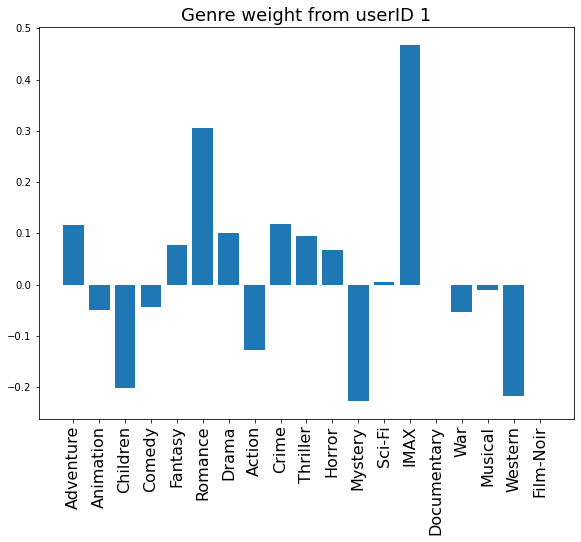

In [204]:
#Starting with the weight of every genre on the current user 
genre_list = np.array(df_genre_lr.columns[4:-2].values)


plt.figure(figsize=(9.6,7.2))
plt.bar(genre_list, genre_coef)
plt.xticks(rotation = 90, size = 16)
plt.title('Genre weight from userID '+str(desiredUserId), size= 18)
plt.show()

## 3.2 Using the movie tags as descriptive variables

In [205]:
#We use our recently created function
tag_preds, tag_coef = lrmodels(df_tag_lr, movies_tag,'tag')
tag_preds

MSE: 0.10, R-squared: 0.05


,title,year,tag_model_ratings,tag_high_rating
0,Toy Story,1995,3.709776,0
1,Jumanji,1995,3.500000,0
2,Grumpier Old Men,1995,3.775913,0
3,Waiting to Exhale,1995,4.029582,1
4,Father of the Bride Part II,1995,3.588782,0
...,...,...,...,...
10376,The Gunman,2015,3.492689,0
10377,Spring,2015,3.868236,0
10378,Get Hard,2015,3.317854,0
10379,Phoenix,2014,3.718485,0


In [206]:

print(f"userId {desiredUserId} would give an average rating of {tag_preds['tag_model_ratings'].mean():.2f} ± {tag_preds['tag_model_ratings'].std():.2f}",\
        f"and would only give a high rating to {tag_preds['tag_high_rating'].sum()} out of ", \
          f"{tag_preds['tag_high_rating'].count()} ({(tag_preds['tag_high_rating'].sum()/tag_preds['tag_high_rating'].count())*100:.2f}%)")
movie_model_rating_query_id = int(input('Movie ID: \n' ))
print(f"The movie titled {tag_preds.loc[(movie_model_rating_query_id-1),'title']}released in {tag_preds.loc[(movie_model_rating_query_id-1),'year']} ", \
          f"has a predicted rating of {tag_preds.loc[(movie_model_rating_query_id-1),'tag_model_ratings']:.2f} from userId {desiredUserId} ")             

userId 1 would give an average rating of 3.63 ± 0.27 and would only give a high rating to 984 out of  10381 (9.48%)


Movie ID: 
 1


The movie titled Toy Story released in 1995  has a predicted rating of 3.71 from userId 1 


In [207]:
#Top positive tags for  userId. I will print it is  a dataframe so I can reorder and print
tag_list = np.array(df_tag_lr.columns[4:-2].values)
tag_weights = pd.DataFrame({'Tag':tag_list, 'Weight':tag_coef})
tag_weights_sorted = tag_weights.sort_values(by='Weight')
print(f"The most negative tags for userID {desiredUserId} are:")
display(tag_weights_sorted.head())
print(f"The most positive tags for userID {desiredUserId} are:")
display(tag_weights_sorted.sort_values(by='Weight',ascending=0).head())

The most negative tags for userID 1 are:


,Tag,Weight
528,humorous,-0.204888
130,biblical,-0.193040
689,mythology,-0.182718
320,dragon,-0.179666
1026,time loop,-0.175760


The most positive tags for userID 1 are:


,Tag,Weight
275,cult film,0.294175
1065,utopia,0.183851
849,revenge,0.167437
613,love story,0.162125
629,mars,0.160852


# 4. kNN Method

Similar to when using Linear Regression, I am doing a quick kNN modeling. I created a function to save lines of code. The function has a for cycle and an input prompt used to optimize the number of neighbors to be used for the final model. Similar to the linear regression models, we are using the Regressor and not the Classifier so we can have a little more information available.

In [211]:
def knnmodels(user_rated_df, full_df, descriptive_variable_name):
    X = user_rated_df.iloc[:, 4:-2]                                                                         #Input features (genres)
    y = user_rated_df['rating']                                                                             #Target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)                #Test train split of 80/20
    neighbors = np.arange(1, 13)
    train_accuracies = {}
    test_accuracies = {}
    for neighbor in neighbors:
        knn = KNeighborsRegressor(n_neighbors=neighbor)
        knn.fit(X_train, y_train)
        train_accuracies[neighbor] = knn.score(X_train, y_train)
        test_accuracies[neighbor] = knn.score(X_test, y_test)
    plt.title("KNN: Varying Number of Neighbors")
    plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
    plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
    plt.legend()
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Accuracy")
    plt.show()
    n_neighbors=int(input('kNN neighbors: \n' ))
    knn = KNeighborsRegressor(n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean squared error:", mse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)
    movies_full_prediction = full_df.copy()
    model_ratings = knn.predict(full_df.iloc[:, 3:-1])
    movies_full_prediction[descriptive_variable_name+'_model_ratings'] = model_ratings.tolist()
    movies_clean_ratings = movies_full_prediction.iloc[:,[1,2,-1]]
    movies_clean_ratings
    movies_final = movies_clean_ratings.copy()
    movies_final[descriptive_variable_name+'_high_rating'] = movies_final[descriptive_variable_name+'_model_ratings'].apply( lambda x: 1 if x >= 4 else 0)
    return movies_final

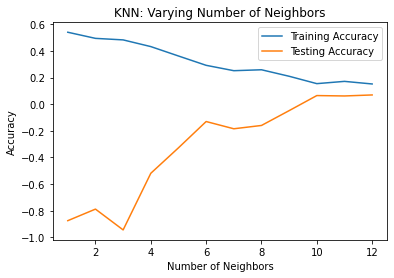

kNN neighbors: 
 11


Mean squared error: 0.09651711924439196
R-squared: 0.0616391184573003


,title,year,genre_model_ratings,genre_high_rating
0,Toy Story,1995,3.772727,0
1,Jumanji,1995,3.863636,0
2,Grumpier Old Men,1995,3.590909,0
3,Waiting to Exhale,1995,3.636364,0
4,Father of the Bride Part II,1995,3.590909,0
...,...,...,...,...
27273,Kein Bund für's Leben,2007,3.590909,0
27274,"Feuer, Eis & Dosenbier",2002,3.590909,0
27275,The Pirates,2014,4.045455,1
27276,Rentun Ruusu,2001,3.636364,0


In [212]:
#We use our recently created function for genre
genre_preds_knn = knnmodels(df_genre_lr, movies_genre,'genre')
genre_preds_knn

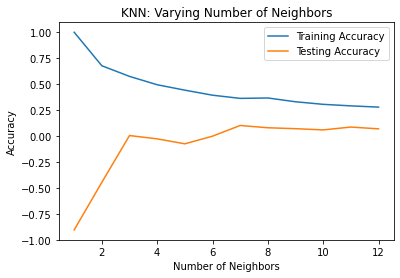

kNN neighbors: 
 7


Mean squared error: 0.09096209912536442
R-squared: 0.10138248847926301


,title,year,tag_model_ratings,tag_high_rating
0,Toy Story,1995,3.642857,0
1,Jumanji,1995,3.500000,0
2,Grumpier Old Men,1995,3.500000,0
3,Waiting to Exhale,1995,3.500000,0
4,Father of the Bride Part II,1995,3.500000,0
...,...,...,...,...
10376,The Gunman,2015,3.500000,0
10377,Spring,2015,3.857143,0
10378,Get Hard,2015,3.428571,0
10379,Phoenix,2014,3.857143,0


In [213]:
#We use our recently created function for tags
tag_preds_knn = knnmodels(df_tag_lr, movies_tag,'tag')
tag_preds_knn

# 5. Summary and concluding remarks

For this exercise I had access to a dataset, where I had to manage the data to make predictions whether a user gives a movie a high rating. The fields I chose to work with from the dataset were movieId, title, genre, rating, userID. The only EDA done was visualizing a preview of the structure of the datasets. The feature engineering for this small project was simple. I first decided to work with two kinds of descriptive variables, genres and movie tags. Some ideas for this work were inspired by research into published code for this dataset or similar problems.

The highlight for the creation of the genres dataframe was the use of One Hot Encoding to assign a value of 1 whether a movie could be described with a corresponding genre. On the other hand, to create the dataframe to work with movie tags a similar strategy was used, but portraying the idea was a little more complex. Each movieId would have value for each column corresponding to a tag. To make this, we first needed to merge two of the base datasets so we could have the relevance that each tag (by name) has on each registered movie. To translate this two columns into new columns and values for the main dataframe the help of ChatGPT was required. After both dataframes are created, I added an input prompt for the desired userId that we want to do our prediction on. After the prompt is filled, we extract from one of the base data sets the films that have been rated by this user, along with the value of the rating and merge this dataframe with the ones containing the genre and tag descriptive variables. 

The models I have experience with are Linear Regression, Logistic Regression and kNN. During this work I planned mainly for Linear Regression, because I believe that some information could be lost by using Logistic Regression to get a binary value, so I prefer to first obtain a continuous variable and than transform it into the binary value. kNN Regressor was used as a last moment consideration just as an extra predictor. Linear Regression was done simply and was trained and tested with a standard 80/20 train test split for both descriptors. kNN Regression also used an 80/20 split and I used a fitting sample code from one of the courses I took to choose the optimal number of neighbors to avoid over and underfitting. I am aware that these may not be the best models for these datasets (see below in Improvement ideas) and this is seen in the results of the models. For both methods and descriptive variables for r^2 we get an extremely low value of 0.05, however we get relatively low values of MSE and for kNN Regressor we get even smaller values of MSE, so the models are not good fits, but are making accurate predictions, this could mean that this methods are being overfitting due to becoming too complex because of the large number of variables.

After getting the response variables, I added an input to get the predicted rating for a desired movieId and another output of a small summary of the number of films that are predicted to get a high rating. For the genre model I added a plot that represents the weight that each genre has on the selected User while for the tag models, a small dataframe output of the top 5 most favorable and top 5 worst tags for the user. 

# 6. How could I improve this work? 

If I had more time, I would... 

- In depth research on other common Algorithms, to make a better choice on the model to use
- More in depth EDA phase, this could lead to better decision making for the model and help predict some tendencies
- Explore other similar problems to brainstorm ideas
- Filter noisy descriptive variables for both genre and tag models
- More explicit comparison of the results obtained by both methods, model types and the reference
- Debug for code optimization, automation and cleanup
- If this was not for evaluation, I would omit some cell outputs after taking a glance
- I used some of the time to setup SQL on my laptop, which gave me some trouble and in the end, I didn't use it